<a href="https://colab.research.google.com/github/luckedenn/DataScienceProjects/blob/main/Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lucascha","key":"2a2906fa9a7059179e78d631e2593097"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c data-slayer-2-0-machine-learning-competition

 99% 615M/623M [00:05<00:00, 125MB/s]
100% 623M/623M [00:05<00:00, 124MB/s]


In [ ]:
!unzip data-slayer-2-0-machine-learning-competition.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/test/a95401b7fb.jpg  
  inflating: ./data/test/a99cfdf792.jpg  
  inflating: ./data/test/a9a1459119.jpg  
  inflating: ./data/test/aa3f6b8b9b.jpg  
  inflating: ./data/test/aa5863c371.jpg  
  inflating: ./data/test/aa6e0b3612.jpg  
  inflating: ./data/test/aa7aa9aa08.jpg  
  inflating: ./data/test/aaa23e214a.jpg  
  inflating: ./data/test/ab215ad4c5.jpg  
  inflating: ./data/test/ab28414f6c.jpg  
  inflating: ./data/test/ab64f1da10.jpg  
  inflating: ./data/test/ab6ec1b1bc.jpg  
  inflating: ./data/test/ab86fd367d.jpg  
  inflating: ./data/test/abfb060e67.jpg  
  inflating: ./data/test/ac2ba4c78f.jpg  
  inflating: ./data/test/ac4ce157eb.jpg  
  inflating: ./data/test/ac5a4a0d8e.jpg  
  inflating: ./data/test/ac69540f73.jpg  
  inflating: ./data/test/ac6c7b4272.jpg  
  inflating: ./data/test/ac7e79c3d1.jpg  
  inflating: ./data/test/ac8fe7e8ba.jpg  
  inflating: ./data/test/acafbb3284.jpg  
  inflating: ./data/test/

In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 13.0 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import os
import shutil
from sklearn.metrics import accuracy_score
import numpy as np

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Step 1: Prepare Dataset
# Define folder paths
data_dir = './data/train'  # Path to your training data
output_dir = './yolo_dataset'  # Path where YOLO dataset will be created

In [ ]:
# Define class labels
class_labels = ['non_fall', 'fall']

# Create YOLO dataset structure
if not os.path.exists(output_dir):
    os.makedirs(os.path.join(output_dir, 'images/train'))
    os.makedirs(os.path.join(output_dir, 'images/val'))
    os.makedirs(os.path.join(output_dir, 'labels/train'))
    os.makedirs(os.path.join(output_dir, 'labels/val'))

# Split data into training and validation sets
from sklearn.model_selection import train_test_split

all_images = []
all_labels = []

for subject in os.listdir(data_dir):
    subject_path = os.path.join(data_dir, subject)
    for subfolder in ['fall', 'non_fall']:
        subfolder_path = os.path.join(subject_path, subfolder)
        if os.path.exists(subfolder_path):
            for activity_folder in os.listdir(subfolder_path):
                activity_folder_path = os.path.join(subfolder_path, activity_folder)
                if os.path.isdir(activity_folder_path):
                    for image_name in os.listdir(activity_folder_path):
                        image_path = os.path.join(activity_folder_path, image_name)
                        if image_name.lower().endswith('.jpg'):
                            all_images.append(image_path)
                            all_labels.append(class_labels.index(subfolder))

# Split data into train and val
train_images, val_images, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)

In [ ]:
# Copy images and create YOLO annotations
def create_yolo_files(images, labels, split):
    for img_path, label in zip(images, labels):
        # Copy image to YOLO dataset folder
        dst_image_path = os.path.join(output_dir, f'images/{split}', os.path.basename(img_path))
        shutil.copy(img_path, dst_image_path)

        # Create annotation file
        annotation_path = os.path.join(output_dir, f'labels/{split}', os.path.splitext(os.path.basename(img_path))[0] + '.txt')
        with open(annotation_path, 'w') as f:
            # For classification task, bounding box spans entire image
            f.write(f"{label} 0.5 0.5 1.0 1.0\n")

create_yolo_files(train_images, train_labels, 'train')
create_yolo_files(val_images, val_labels, 'val')

In [ ]:
# Step 2: Create data.yaml file for YOLO with absolute paths
train_path = os.path.abspath(os.path.join(output_dir, 'images/train'))
val_path = os.path.abspath(os.path.join(output_dir, 'images/val'))

with open(os.path.join(output_dir, 'data.yaml'), 'w') as f:
    f.write(f"train: {train_path}\n")
    f.write(f"val: {val_path}\n")
    f.write(f"nc: {len(class_labels)}\n")
    f.write(f"names: {class_labels}\n")

In [ ]:
with open(os.path.join(output_dir, 'data.yaml'), 'r') as f:
    print(f.read())

train: /content/yolo_dataset/images/train
val: /content/yolo_dataset/images/val
nc: 2
names: ['non_fall', 'fall']



In [ ]:
import glob

train_images_count = len(glob.glob('./yolo_dataset/images/train/*'))
val_images_count = len(glob.glob('./yolo_dataset/images/val/*'))

print(f"Train Images: {train_images_count}")
print(f"Validation Images: {val_images_count}")

Train Images: 169
Validation Images: 143


In [ ]:
model = YOLO('yolov8n.pt')
model.train(data=os.path.join(output_dir, 'data.yaml'), epochs=30, imgsz=224, batch=16, augment=True)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./yolo_dataset/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

train: Scanning /content/yolo_dataset/labels/train.cache... 169 images, 0 backgrounds, 0 corrupt: 100%|██████████| 169/169 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/yolo_dataset/labels/val.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]

Plotting labels to runs/detect/train7/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs/detect/train7
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      1.162      3.108      1.437         27        224: 100%|██████████| 11/11 [00:20<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]

                   all        143        143     0.0102          1      0.523      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G     0.4531      2.329      1.015         32        224: 100%|██████████| 11/11 [00:18<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]

                   all        143        143     0.0471          1       0.57       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G     0.3604      1.559     0.9426         26        224: 100%|██████████| 11/11 [00:17<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]

                   all        143        143      0.841        0.5       0.62       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G     0.3496      1.213     0.9406         26        224: 100%|██████████| 11/11 [00:17<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]

                   all        143        143      0.498          1      0.621      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G     0.3334      1.091     0.9221         31        224: 100%|██████████| 11/11 [00:20<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]

                   all        143        143      0.459      0.922       0.68       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G     0.2984      1.018     0.9119         32        224: 100%|██████████| 11/11 [00:17<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]

                   all        143        143      0.614      0.944      0.731      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G     0.2789     0.9463     0.9043         25        224: 100%|██████████| 11/11 [00:17<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        143        143      0.665      0.944      0.675      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G     0.2931      0.884     0.9098         26        224: 100%|██████████| 11/11 [00:18<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]

                   all        143        143      0.569        0.9       0.78      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G     0.2862     0.8952     0.8996         28        224: 100%|██████████| 11/11 [00:18<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]

                   all        143        143      0.582      0.911      0.759      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G     0.2611     0.8263     0.9002         30        224: 100%|██████████| 11/11 [00:17<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]

                   all        143        143      0.691      0.944      0.853       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G     0.2449     0.7845     0.9002         27        224: 100%|██████████| 11/11 [00:17<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]

                   all        143        143      0.631      0.725      0.806      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G     0.2568     0.7667     0.8991         31        224: 100%|██████████| 11/11 [00:18<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]

                   all        143        143      0.628      0.746      0.748      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G      0.253     0.7549     0.8971         32        224: 100%|██████████| 11/11 [00:17<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]

                   all        143        143      0.756      0.783      0.787      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G     0.2303     0.6463     0.8884         20        224: 100%|██████████| 11/11 [00:17<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]

                   all        143        143      0.763      0.839      0.878      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G     0.2092      0.649     0.8797         27        224: 100%|██████████| 11/11 [00:19<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]

                   all        143        143      0.824      0.865      0.859      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G     0.2034     0.6209      0.881         26        224: 100%|██████████| 11/11 [00:17<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]

                   all        143        143      0.772      0.937      0.899      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G     0.2039     0.5771     0.8934         26        224: 100%|██████████| 11/11 [00:17<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]

                   all        143        143      0.867       0.85      0.895      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G     0.1854     0.5939     0.8858         32        224: 100%|██████████| 11/11 [00:17<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]

                   all        143        143      0.801      0.866      0.915      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G     0.1873     0.6099     0.8876         32        224: 100%|██████████| 11/11 [00:19<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]

                   all        143        143      0.842      0.857      0.907      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G     0.1742     0.6376     0.8853         29        224: 100%|██████████| 11/11 [00:18<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]

                   all        143        143      0.789      0.831      0.846      0.846


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G     0.1687      1.249     0.8606          9        224: 100%|██████████| 11/11 [00:17<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]

                   all        143        143      0.796      0.888      0.898      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G     0.1526     0.6644      0.852          9        224: 100%|██████████| 11/11 [00:19<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]

                   all        143        143      0.897      0.879      0.929      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G     0.1618      0.634     0.8581          9        224: 100%|██████████| 11/11 [00:17<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]

                   all        143        143      0.912      0.856      0.929      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G     0.1614     0.5297     0.8528          9        224: 100%|██████████| 11/11 [00:17<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]

                   all        143        143      0.878       0.86      0.932      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G     0.1574     0.5102     0.8441          9        224: 100%|██████████| 11/11 [00:18<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]

                   all        143        143      0.884      0.872      0.922      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G      0.172     0.5308     0.8409          9        224: 100%|██████████| 11/11 [00:17<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]

                   all        143        143      0.863      0.857      0.922      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G     0.1692     0.4961     0.8506          9        224: 100%|██████████| 11/11 [00:17<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]

                   all        143        143      0.878      0.847      0.931      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G     0.1452     0.4981     0.8447          9        224: 100%|██████████| 11/11 [00:18<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]

                   all        143        143      0.921       0.88      0.929      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G     0.1418     0.4378     0.8396          9        224: 100%|██████████| 11/11 [00:17<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]

                   all        143        143      0.908      0.901      0.933      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G     0.1145     0.4598     0.8365          9        224: 100%|██████████| 11/11 [00:18<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]

                   all        143        143      0.912      0.898      0.945      0.945



30 epochs completed in 0.201 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 6.2MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


                   all        143        143      0.912      0.917      0.955      0.955
              non_fall         98         98      0.878       0.99       0.97       0.97
                  fall         45         45      0.945      0.844      0.941      0.941
Speed: 0.2ms preprocess, 58.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train7


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aac1027cac0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
# Step 4: Evaluate Model on Validation Set
val_predictions = []
val_image_names = []
model.eval()

for img_path in val_images:
    results = model.predict(source=img_path, imgsz=224, save=False, verbose=False)
    if results[0].boxes:  # If predictions exist
        pred_label = int(results[0].boxes.cls[0].item())  # Get the predicted class
    else:
        pred_label = 0  # Default to 'non_fall' if no prediction
    val_predictions.append(pred_label)
    val_image_names.append(os.path.basename(img_path))

# Compute validation accuracy
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Validation Accuracy: 90.22%


In [ ]:
# Step 5: Test on Unseen Data
test_dir = './data/test'  # Path to test data
test_predictions = []
test_image_names = []

for image_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, image_name)
    if image_name.lower().endswith('.jpg'):
        results = model.predict(source=img_path, imgsz=224, save=False, verbose=False)
        if results[0].boxes:  # If predictions exist
            pred_label = int(results[0].boxes.cls[0].item())  # Get the predicted class
        else:
            pred_label = 0  # Default to 'non_fall' if no prediction
        test_predictions.append(pred_label)
        test_image_names.append(image_name)

# Print predictions for test data
for img_name, pred in zip(test_image_names, test_predictions):
    print(f"Image: {img_name}, Predicted Label: {class_labels[pred]}")


Image: f949cd3b02.jpg, Predicted Label: non_fall
Image: fa7efaa482.jpg, Predicted Label: non_fall
Image: 0fc0f3fe24.jpg, Predicted Label: non_fall
Image: 2297123d87.jpg, Predicted Label: non_fall
Image: aaa23e214a.jpg, Predicted Label: non_fall
Image: c515d7057a.jpg, Predicted Label: non_fall
Image: 42250d6d18.jpg, Predicted Label: fall
Image: a4ad62c721.jpg, Predicted Label: non_fall
Image: 8db8680806.jpg, Predicted Label: non_fall
Image: b3857db71a.jpg, Predicted Label: non_fall
Image: dd0a309a5f.jpg, Predicted Label: fall
Image: 244a426a24.jpg, Predicted Label: non_fall
Image: ae8c20ce56.jpg, Predicted Label: non_fall
Image: 6b9fa95e31.jpg, Predicted Label: non_fall
Image: c70fc39660.jpg, Predicted Label: fall
Image: 9997cccd02.jpg, Predicted Label: non_fall
Image: 3e94660d3e.jpg, Predicted Label: non_fall
Image: c7608d04a8.jpg, Predicted Label: fall
Image: 809df45153.jpg, Predicted Label: non_fall
Image: d0c198ab9b.jpg, Predicted Label: non_fall
Image: 61a25ffedb.jpg, Predicted Lab

Confusion Matrix:
 [[512  10]
 [ 74 263]]


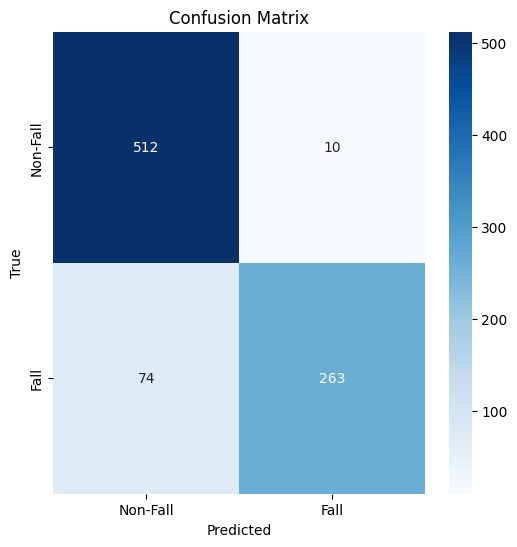

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix dan Classification Report
cm = confusion_matrix(val_labels, val_predictions)
print("Confusion Matrix:\n", cm)
# Visualisasi confusion matrix menggunakan seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import pandas as pd
# Step 6: Create Submission File
predictions = []
for name, pred in zip(test_image_names, test_predictions):
    predictions.append({'id': name, 'label': pred})

predictions_df = pd.DataFrame(predictions)
submission_path = 'Submission2.csv'
predictions_df.to_csv(submission_path, index=False)

print(f"Submission file saved to {submission_path}")

Submission file saved to Submission2.csv


In [ ]:
df = pd.read_csv('Submission.csv')
df.head()

,id,label
0,f949cd3b02.jpg,0
1,fa7efaa482.jpg,0
2,0fc0f3fe24.jpg,0
3,2297123d87.jpg,0
4,aaa23e214a.jpg,0
